<a href="https://colab.research.google.com/github/Bhargavi1504/Regression-algorithms/blob/main/Linear_algorithm_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1.data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder


np.random.seed(42)
n_samples=1000

missing_fraction = 0.1
duplicate_fraction = 0.05
outlier_fraction = 0.03

#functions
def random_generator_cat(choices,n):
  return np.random.choice(choices,n)

def generate_dates(n):
  base = datetime.today()
  return [base - timedelta(days=random.randint(0,2000)) for _ in range(n_samples)]

#raw features
Age = np.random.randint(5,80,n_samples)
experience=np.clip(Age - np.random.randint(18,25,n_samples),0,None)
education= random_generator_cat(['Bachelors','Masters','PHD'],n_samples)
city = random_generator_cat(['New York', 'San Francisco', 'Chicago', 'Austin'],n_samples)
job_role = random_generator_cat(['Data Scientist','Data Analyst','Data Engineer'],n_samples)
gender = random_generator_cat(['Male', 'Female', 'Other'], n_samples)
join_date = generate_dates(n_samples)
performance = np.random.normal(70,10,n_samples).round(2)
working_hours= np.random.normal(40,5,n_samples).round(1)
married = np.random.choice([0, 1], n_samples)
social_activity = np.random.normal(2, 1, n_samples).round(1)

# Multicollinear & noisy features
salary=experience * 3000 + Age* 200 + np.random.normal(0,1000,n_samples)
loan_amount = salary * 0.3 + np.random.normal(0,5000,n_samples)
spending_score= np.random.normal(50,20,n_samples).round(1)
rating = np.random.randint(1, 6, n_samples)
target_salary = salary * 1.1 + np.random.normal(0, 3000, n_samples)
will_churn = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])


# 4. Create DataFrame
d=pd.DataFrame({
    'Age': Age,
    'salary': salary.round(2),
    'experience': experience,
    'education_level': education,
    'city': city,
    'job_role': job_role,
    'gender': gender,
    'join_date': join_date,
    'performance': performance,
    'working_hours': working_hours,
    'married': married,
    'loan_amount': loan_amount.round(2),
    'spending_score': spending_score,
    'rating': rating,
    'social_activity': social_activity,
    'target_salary': target_salary.round(2),
    'will_churn': will_churn
})

# Inject Missing Values
for i in d.columns:
  d.loc[d.sample(frac = missing_fraction).index,i]=np.nan

# Inject Duplicates
num_duplicates = int(n_samples * duplicate_fraction )
duplicate_rows = d.sample(num_duplicates)
d=pd.concat([d,duplicate_rows],ignore_index=True)

# Inject Outliers
def inject_outliers(d,column,fraction = outlier_fraction,factor=10):
    num_outliers = int(len(d)* fraction)
    indices = np.random.choice(d.index,num_outliers,replace=True)
    d.loc[indices,column] *= factor

inject_outliers(d, 'salary')
inject_outliers(d, 'loan_amount')

# Encode Categorical for ML
d_encoded=d.copy()
label_cols= ['education_level', 'city', 'job_role', 'gender']
encoders={}
for c in label_cols:
  le=LabelEncoder()
  d_encoded[c] = d_encoded[c].astype(str) #avoid NaNs
  d_encoded[c]=le.fit_transform(d_encoded[c])
  encoders[c]= le

# 9. Export
# -------------------------------
d.to_csv("dirty_dataset.csv", index=False)
d_encoded.to_csv("dirty_dataset_encoded.csv", index=False)

print("✅ Dirty dataset and encoded version saved!")


✅ Dirty dataset and encoded version saved!


In [ ]:
#2. loading dataset
dlr=pd.read_csv("dirty_dataset_encoded.csv")
print('initial_shape',dlr.shape)
print('head',dlr.head())

initial_shape (1050, 17)
head     Age     salary  experience  education_level  city  job_role  gender  \
0  56.0  106971.40        32.0                2     1         0       0   
1  19.0    6602.68         NaN                0     0         0       1   
2  76.0  179121.05        55.0                1     0         0       3   
3  65.0  153358.40        47.0                1     2         0       0   
4  25.0   22533.10         7.0                1     3         0       0   

                    join_date  performance  working_hours  married  \
0  2024-10-26 19:45:55.405282        68.22           42.3      NaN   
1  2025-01-22 19:45:55.405282        56.36           43.3      NaN   
2  2024-07-25 19:45:55.405282          NaN           50.3      0.0   
3  2023-09-13 19:45:55.405282        63.75           42.9      0.0   
4                         NaN        68.03           43.2      1.0   

   loan_amount  spending_score  rating  social_activity  target_salary  \
0          NaN          

In [ ]:
#3. data cleaning
#3.1 Drop Missing Target Rows
dlr=dlr.dropna(subset=['target_salary'])
print('After dropping null targets',dlr.shape)

After dropping null targets (946, 17)


In [ ]:
#3.2 Impute Missing Values--numeric
from sklearn.impute import SimpleImputer
num_c=dlr.select_dtypes(include=['int64','float64']).columns

imputer=SimpleImputer(strategy='median')
dlr[num_c]= imputer.fit_transform(dlr[num_c])

#--cat
dlr['join_date']=dlr['join_date'].fillna(dlr['join_date'].mode()[0])

print('Missing values are handled:\n', dlr.isnull().sum().sort_values(ascending=False))

Missing values are handled:
 Age                0
salary             0
experience         0
education_level    0
city               0
job_role           0
gender             0
join_date          0
performance        0
working_hours      0
married            0
loan_amount        0
spending_score     0
rating             0
social_activity    0
target_salary      0
will_churn         0
dtype: int64


In [ ]:
#3.3 Remove Multicollinearity (VIF > 10)
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(x):
  vif_data=pd.DataFrame()
  vif_data['feature']=x.columns
  vif_data['VIF']=[variance_inflation_factor(x.values,i)
                    for i in range(len(x.columns))]
  return vif_data

x_vif = dlr.drop(columns=['target_salary','will_churn','join_date','Age','experience'])
vif_result = calculate_vif(x_vif)
print(vif_result.sort_values(by='VIF',ascending=False))

#drop high vif cols
high_vif=vif_result[vif_result['VIF']>10]['feature'].tolist()
dlr=dlr.drop(columns=high_vif)
print("Dropped for multicollinearity:", high_vif)


            feature        VIF
6     working_hours  39.074198
5       performance  34.719270
9    spending_score   7.764458
10           rating   5.545375
11  social_activity   5.418133
2              city   2.745200
3          job_role   2.617358
4            gender   2.595451
1   education_level   2.392436
7           married   1.780477
8       loan_amount   1.496924
0            salary   1.330584
Dropped for multicollinearity: ['performance', 'working_hours']


In [ ]:
#3.4 Remove Outliers with IQR Method
def remove_outliers(d,i):
  q1=d[i].quantile(0.25)
  q3=d[i].quantile(0.75)
  IQR=q3-q1
  lower=q1 - 1.5 * IQR
  upper=q3 + 1.5 * IQR
  mask=(d[i]>=lower)&(d[i]<=upper)
  return d[mask]

for col in['target_salary']:
  d=remove_outliers(dlr,col)

print("Shape after outlier removal:", dlr.shape)

Shape after outlier removal: (946, 15)


In [ ]:
#3.5 Scale the Data
from sklearn.preprocessing import StandardScaler

features = dlr.drop(columns=['target_salary', 'will_churn', 'join_date']).columns
X = dlr[features]
y = dlr['target_salary']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
#model training
#Step 4: Train the Linear Regression Model
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model=LinearRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

#evaluation
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)

print("📉 RMSE:", round(rmse, 2))
print("📈 R² Score:", round(r2, 4))


📉 RMSE: 16381.26
📈 R² Score: 0.9459


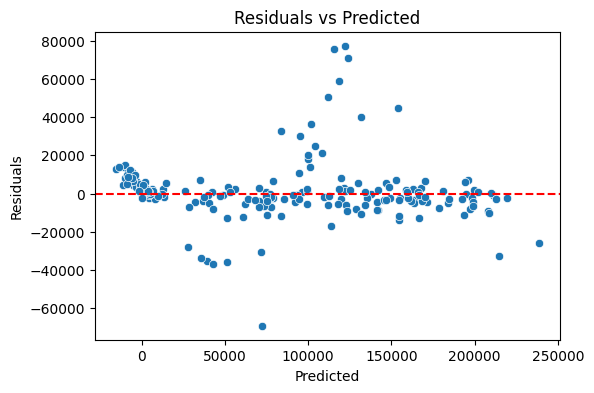

In [ ]:
#Step 5: Diagnostics & Assumption Checks
#Residuals vs Predicted (Linearity & Homoscedasticity)
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

#If you see pattern/funnel → non-linearity or heteroscedasticity is present

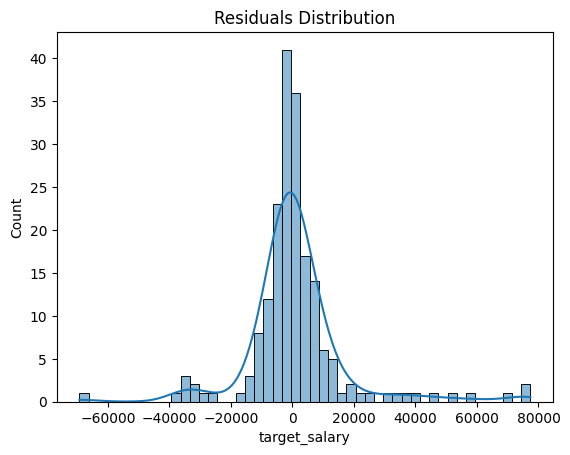

In [ ]:
#Residual Distribution (Normality)
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

#Histogram should resemble a bell curve
#Skew or multi-modal → may indicate need for log-transform or other nonlinear models later

/tmp/ipython-input-91-887952309.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,x_train_dlr,plot_type='bar')


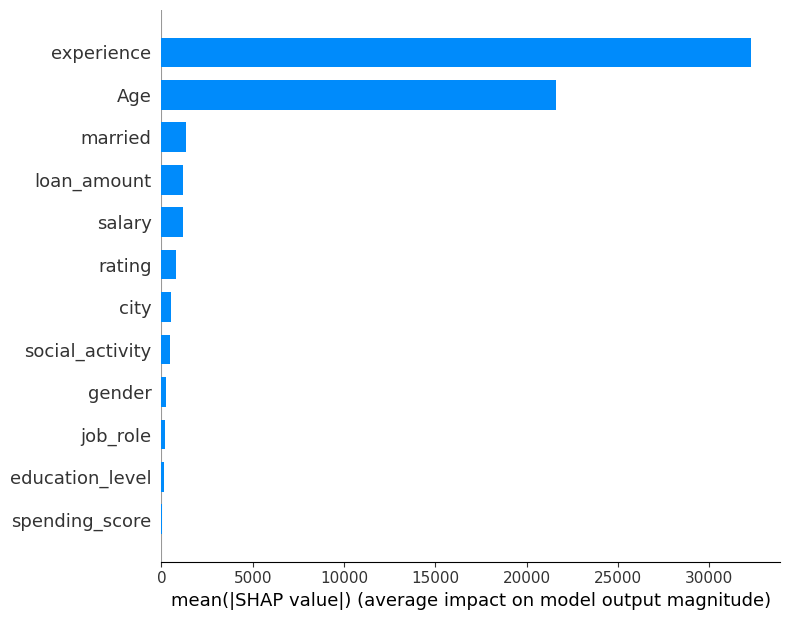

In [ ]:
x_train_dlr = pd.DataFrame(x_train, columns=features)

import shap
explainer=shap.Explainer(model,x_train_dlr)
shap_values=explainer(x_train_dlr)

shap.summary_plot(shap_values,x_train_dlr,plot_type='bar')
